In [1]:
import sys
sys.path.append('../') # To import from parent dir
import time
import os
import ast

import pandas as pd
from itertools import chain

from util.GrammarBasedUtil import *

import matplotlib.pyplot as plt

In [2]:
# ---- Initialize all context parameters that will be used ----
# Note: Read the alignment hints above
systems = ["category"]
applications = ["application"]
uiGroup1 = ["workbook","browser_url","title"]
uiGroup2 = ["current_worksheet"] 
uiGroup3 = ["cell_range","cell_range_number"]
uiElement = ["mouse_coord","tag_category","xpath","event_src_path","event_dest_path","tag_name","tag_title","tag_href",
             "tag_innerText","tab_pinned","tab_audible","tab_muted","window_ingognito","tab_moved_from_index","tab_moved_to_index","id"]
actions = ["concept:name","eventQual"]

# ---- Add all hierarchy levels into a list ----
hierarchy_list_smartrpa = [systems, applications, uiGroup1, uiGroup2, uiGroup3, uiElement, actions]
hierarchy_columns_smartrpa = list(chain.from_iterable([h for h in hierarchy_list_smartrpa if h]))

# ---- Define the path in which all files are stored ----
folder_path_smartRPA = "../logs/smartRPA/percentageComparison/"

percentagData_filename = "validationDataPercentage.csv"

# ---- Getting the relevant files from the folder and sorting them into different lists for processing ----
isSmartRPA = True
sep_smartrpa = ","
percentageLogs = []

for file in os.listdir(folder_path_smartRPA):
    if file.startswith("LenLog"):
        percentageLogs.append(file)

# Check if data created for percentage based comparison is available
try:
    percentageValData = pd.read_csv(folder_path_smartRPA + percentagData_filename)
    percentageValAvailable = True
except FileNotFoundError as e:
    print(f"Could not read {percentagData_filename} from the folder.\n{e}")
    percentageValAvailable = False

In [3]:
# ---- Define the path in which all files are stored ----
folder_path_leno = "../logs/leno/"

sep_leno = ";"
leno_SR_RT_plus = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_plus.csv", sep=sep_leno)
# leno_SR_RT_plus_ground_truth = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_plus_ground_truth.csv", sep=sep_leno)
# leno_SR_RT_parallel = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_parallel.csv", sep=sep_leno)
# leno_SR_RT_parallel_ground_truth = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_parallel_ground_truth.csv", sep=sep_leno)

# ---- Initialize all context parameters that will be used ----
# Note: Read the alignment hints above
systems = []
applications = ["targetApp"]
uiGroup1 = ["url","target.workbookName"]
uiGroup2 = ["target.sheetName"]
uiElement = ["target.id","target.tagName","target.type","target.name","target.href"]
actions = ["eventType"]

# ---- Add all hierarchy levels into a list ----
hierarchy_list_leno = [applications, uiGroup1, uiGroup2, uiElement, actions]
# Flatten the hierarchy list and remove empty lists
hierarchy_columns_leno = list(chain.from_iterable([h for h in hierarchy_list_leno if h]))

Encoding of unique subsequences - Counting their overall occurances in the log

In [4]:
# Agostinelli
# hierarchy_columns = hierarchy_columns_smartrpa
# log_name_smartRPA = "LenLog_1_1_10_25_2-5_10000.csv"
# file = pd.read_csv(folder_path_smartRPA + log_name_smartRPA, sep=sep_smartrpa)
# log = symbolize_UILog(file, hierarchy_columns)
# print(f"Processing file: {log_name_smartRPA} with {len(log)} events.")
# comparisonVariables = percentageValData.loc[percentageValData['uiLogName'] == log_name_smartRPA]
# insertSpots = comparisonVariables["motifSpots"]
# parsed_spots = insertSpots.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# insert_spots_flat = [int(i) for sublist in parsed_spots for i in sublist]
# insert_spots_set = set(insert_spots_flat)
# print(f"{len(insert_spots_set)} insertion spots.")

# Leno
hierarchy_columns = hierarchy_columns_leno
log = symbolize_UILog(leno_SR_RT_plus, hierarchy_columns)

# ---- Time the original implementation ----
encoding_df, symbols, two_gram_df = re_pair(log)
last_entry = len(encoding_df["new_symbol"])-1
last_encoding = encoding_df["new_symbol"].iloc[last_entry]
print("\n Last Encoded Entry: ",last_encoding)
decoded_symbol = re_pair_decode_symbol(last_encoding, encoding_df, printing=True)

47  unique pairs found so far. Level:  1
63  unique pairs found so far. Level:  2
70  unique pairs found so far. Level:  3
74  unique pairs found so far. Level:  4

 Last Encoded Entry:  bv
bv → (bm, br)
  bm → (ba, WL)
    ba → (WK, z)
      WK → [base symbol]
      z → (WJ, WM)
        WJ → [base symbol]
        WM → [base symbol]
    WL → [base symbol]
  br → (ay, bi)
    ay → (m, e)
      m → (WO, WN)
        WO → [base symbol]
        WN → [base symbol]
      e → (WQ, WP)
        WQ → [base symbol]
        WP → [base symbol]
    bi → (WE, am)
      WE → [base symbol]
      am → (WF, WI)
        WF → [base symbol]
        WI → [base symbol]

Decoding path for symbol 'bv':
Final expansion: ['WK', 'WJ', 'WM', 'WL', 'WO', 'WN', 'WQ', 'WP', 'WE', 'WF', 'WI']



Exec. Time with loops: 2.859 seconds


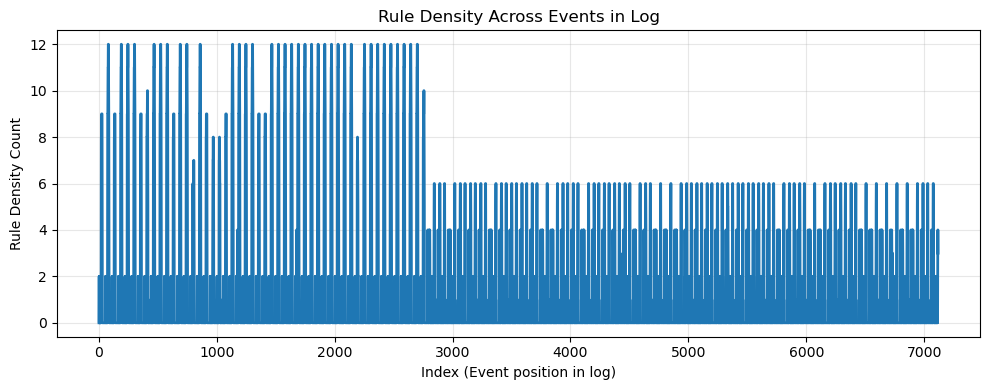

In [9]:
# Initialize the count column
start_time = time.time()
log = generate_density_count(encoding_df, log)
end_time = time.time()
print(f"Exec. Time with loops: {end_time - start_time:.3f} seconds")
plot_density_curve(log)

In [ ]:
max_density, max_groups = find_max_density_groups(log)

print(f"Maximum rule density count: {max_density}")
print("Connected index groups with maximum density:")
for g in max_groups:
    print(f"  {g[0]}–{g[-1]} ({len(g)} elements)")


# >> Wie finden wir jetzt von diesem Punkt aus die richtige Länge an Motifen im Datensatz? 
# Die Punkte haben wir

Maximum rule density count: 12
Connected index groups with maximum density:
  79–80 (2 elements)
  189–190 (2 elements)
  245–246 (2 elements)
  301–302 (2 elements)
  467–468 (2 elements)
  523–524 (2 elements)
  579–580 (2 elements)
  689–690 (2 elements)
  745–746 (2 elements)
  858–859 (2 elements)
  1133–1134 (2 elements)
  1190–1191 (2 elements)
  1246–1247 (2 elements)
  1302–1303 (2 elements)
  1466–1467 (2 elements)
  1522–1523 (2 elements)
  1578–1579 (2 elements)
  1634–1635 (2 elements)
  1691–1692 (2 elements)
  1747–1748 (2 elements)
  1803–1804 (2 elements)
  1859–1860 (2 elements)
  1915–1916 (2 elements)
  1972–1973 (2 elements)
  2028–2029 (2 elements)
  2084–2085 (2 elements)
  2140–2141 (2 elements)
  2252–2253 (2 elements)
  2308–2309 (2 elements)
  2364–2365 (2 elements)
  2420–2421 (2 elements)
  2476–2477 (2 elements)
  2532–2533 (2 elements)
  2588–2589 (2 elements)
  2644–2645 (2 elements)
  2700–2701 (2 elements)


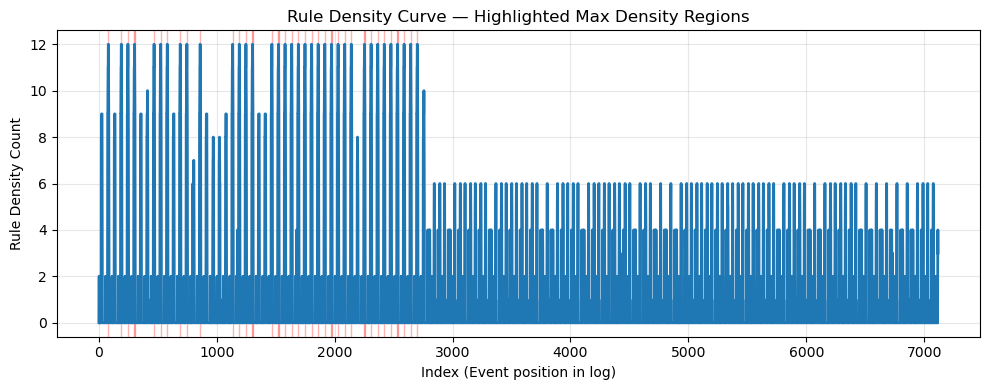

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(log.index, log["rule_density_count"], linewidth=2)
for g in max_groups:
    plt.axvspan(g[0], g[-1], color="red", alpha=0.3)
plt.title("Rule Density Curve — Highlighted Max Density Regions")
plt.xlabel("Index (Event position in log)")
plt.ylabel("Rule Density Count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()